In [1]:
import os
import bigframes.pandas as bf
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import time
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from google.cloud import bigquery

In [2]:
bf.options.bigquery.project = 'credit-business-on-demand-9fd5'

In [3]:
query_tomado_kgiro = f""" SELECT * FROM `dataplatform-nonprd.credit_negocios.documento_kgiro_estudo_vencedores`"""
df_tomado_kgiro = bf.read_gbq(query_tomado_kgiro)
base_tomado_kgiro = df_tomado_kgiro.to_pandas()

In [4]:
base_tomado_kgiro['RootDocumentNumber'] = base_tomado_kgiro['RootDocumentNumber'].astype(int)

In [5]:
'''
df_ = pd.read_csv('document_winners.csv')
df_['RootDocument'] = df_['document'].astype(str).str[:8]
df_ = df_.drop_duplicates(['RootDocument'])
df = df_[['RootDocument']]

#%% Exportacao
client = bigquery.Client(project = 'dataplatform-prd')

table_name = 'credit_negocios.document_winners'

job_config = bigquery.LoadJobConfig(write_disposition = "WRITE_TRUNCATE")
job = client.load_table_from_dataframe(df, table_name, job_config = job_config)
'''

In [6]:
base_w = pd.read_csv('document_winners.csv')

In [7]:
base_w['RootDocumentNumber'] = base_w['document'].astype(str).str[:8].astype(int)

In [8]:
ls_document_w = base_w['RootDocumentNumber'].unique().tolist()

In [9]:
base_tomado_kgiro_w = base_tomado_kgiro[base_tomado_kgiro['RootDocumentNumber'].isin(ls_document_w)]

In [10]:
base_tomado_kgiro_w = base_tomado_kgiro_w.sort_values(by=['RootDocumentNumber', 'ReferenceMonth'])

In [11]:
base_tomado_kgiro_w['var_pct_valorTomadoKGiro'] = (
    base_tomado_kgiro_w
    .groupby('RootDocumentNumber')['valorTomadoKGiro']
    .pct_change())
base_tomado_kgiro_w['diff_valorTomadoKGiro'] = (
    base_tomado_kgiro_w
    .groupby('RootDocumentNumber')['valorTomadoKGiro']
    .diff())

In [12]:
base_tomado_kgiro_w['check_var_pct_valorTomadoKGiro'] = np.where(
    (base_tomado_kgiro_w['var_pct_valorTomadoKGiro'] > 0.1) &
    (~np.isinf(base_tomado_kgiro_w['var_pct_valorTomadoKGiro']) &
    (base_tomado_kgiro_w['var_pct_valorTomadoKGiro'].notna())),
    1, 0)

In [13]:
query_rosa_ventos = f""" SELECT * FROM `dataplatform-prd.credit_business_intelligence.vw_clientes_rosa_ventos`"""
df_rosa_ventos = bf.read_gbq(query_rosa_ventos)
base_rosa_ventos = df_rosa_ventos.to_pandas()

In [14]:
base_rosa_ventos['RootDocumentNumber'] = base_rosa_ventos['documento'].str[:8].astype(int)

In [15]:
base_rosa_ventos_w = base_rosa_ventos[base_rosa_ventos['RootDocumentNumber'].isin(ls_document_w)]

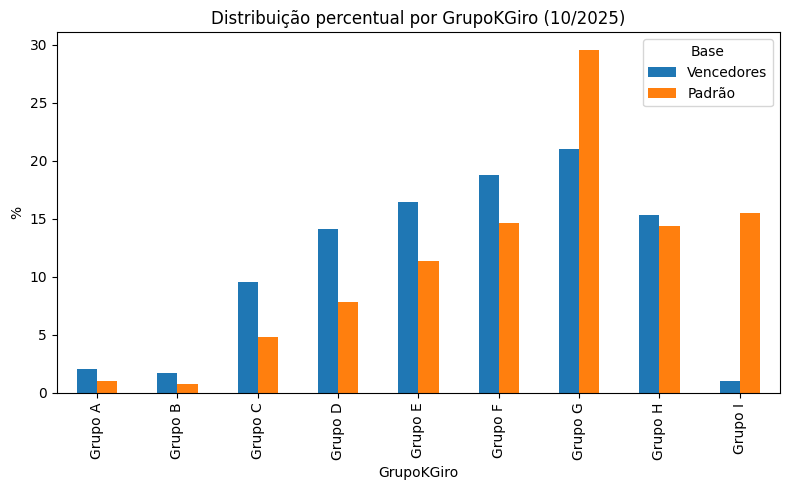

In [16]:
# Create value count percentages for both
df1 = base_rosa_ventos_w['GrupoKGiro'].value_counts(normalize=True) * 100
df2 = base_rosa_ventos['GrupoKGiro'].value_counts(normalize=True) * 100

# Combine them into one DataFrame
df_plot = pd.DataFrame({
    'Vencedores': df1,
    'Padrão': df2
}).fillna(0)  # fill missing categories with 0

# Plot grouped bars
df_plot.plot(kind='bar', figsize=(8,5))
plt.title('Distribuição percentual por GrupoKGiro (10/2025)')
plt.ylabel('%')
plt.xlabel('GrupoKGiro')
plt.legend(title='Base')
plt.tight_layout()
plt.show()

In [17]:
base_kgiro_rosas = base_tomado_kgiro_w.merge(base_rosa_ventos_w,how='left',on=['RootDocumentNumber']).dropna(subset=['GrupoKGiro'])

In [18]:
base_kgiro_rosas[base_kgiro_rosas['check_var_pct_valorTomadoKGiro'] == 1]['diff_valorTomadoKGiro'].sum()

1802538399.92

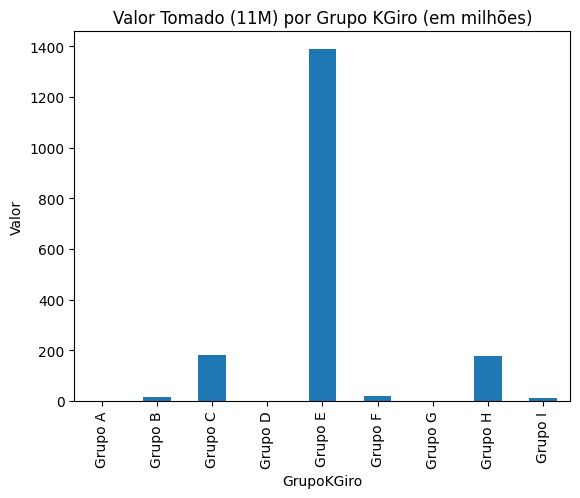

In [19]:
(
    base_kgiro_rosas[base_kgiro_rosas['check_var_pct_valorTomadoKGiro'] == 1]
    .groupby(['GrupoKGiro'])
    .agg(valor_tomado_KGiro=('diff_valorTomadoKGiro', 'sum'))
    .assign(valor_tomado_KGiro=lambda x: x['valor_tomado_KGiro'] / 1_000_000)
    .plot(kind='bar', legend=False)
)

plt.ylabel('Valor')
plt.title('Valor Tomado (11M) por Grupo KGiro (em milhões)')
plt.show()

In [20]:
query_elegibilidade = f""" SELECT * FROM `dataplatform-nonprd.credit_negocios.elegibilidade_estudo_vencedores`"""
df_elegibilidade = bf.read_gbq(query_elegibilidade)
base_elegibilidade = df_elegibilidade.to_pandas()

In [21]:
base_elegibilidade.sort_values(by=['document','data_application_score_processing_at'],inplace=True)

In [22]:
base_elegibilidade_res = base_elegibilidade.groupby(['document']).last().reset_index()

In [23]:
base_elegibilidade_res['RootDocumentNumber'] = base_elegibilidade_res['document'].str[:8].astype(int)

In [24]:
base_elegibilidade_res_w = base_elegibilidade_res[base_elegibilidade_res['RootDocumentNumber'].isin(ls_document_w)]

In [25]:
TOP_N = 15
SCALE_MILLIONS = True  # opcional

# 1) Top N motivos
motivos_abs = base_elegibilidade_res_w['reasons_not_elegible_translation'].value_counts()
top_motivos = motivos_abs.head(TOP_N).index
motivos_pct = (motivos_abs / motivos_abs.sum() * 100).loc[top_motivos]

# 2) Soma de diff_valorTomadoKGiro por motivo (com filtro)
df_reason_docs = (
    base_elegibilidade_res_w.loc[
        base_elegibilidade_res_w['reasons_not_elegible_translation'].isin(top_motivos),
        ['reasons_not_elegible_translation', 'RootDocumentNumber']
    ]
    .drop_duplicates()
)

kgiro_ok = base_tomado_kgiro_w.loc[
    base_tomado_kgiro_w['check_var_pct_valorTomadoKGiro'] == 1,
    ['RootDocumentNumber', 'diff_valorTomadoKGiro']
]

val_sum = (
    df_reason_docs
    .merge(kgiro_ok, on='RootDocumentNumber', how='left')
    .groupby('reasons_not_elegible_translation', dropna=False)['diff_valorTomadoKGiro']
    .sum(min_count=1)
    .reindex(top_motivos)
    .fillna(0.0)
)

# 3) Monta a tabela base (ordem preservada)
tabela = pd.DataFrame({
    'Quantidade': motivos_abs.loc[top_motivos].astype('int64'),
    'Percentual': motivos_pct.astype('float'),
    'Valor_Soma': val_sum.astype('float')
})
tabela.index.name = 'Motivo'  # só para ficar bonito

# 4) Coluna de exibição em milhões + rename (se for usar no gráfico)
if SCALE_MILLIONS:
    tabela['Valor_Soma_exib'] = (tabela['Valor_Soma'] / 1_000_000).astype('float')
    # se quiser usar o nome final no heatmap:
    tabela = tabela.rename(columns={'Valor_Soma_exib': 'Valor KGiro'})
    valor_col_plot = 'Valor KGiro'
else:
    valor_col_plot = 'Valor_Soma'

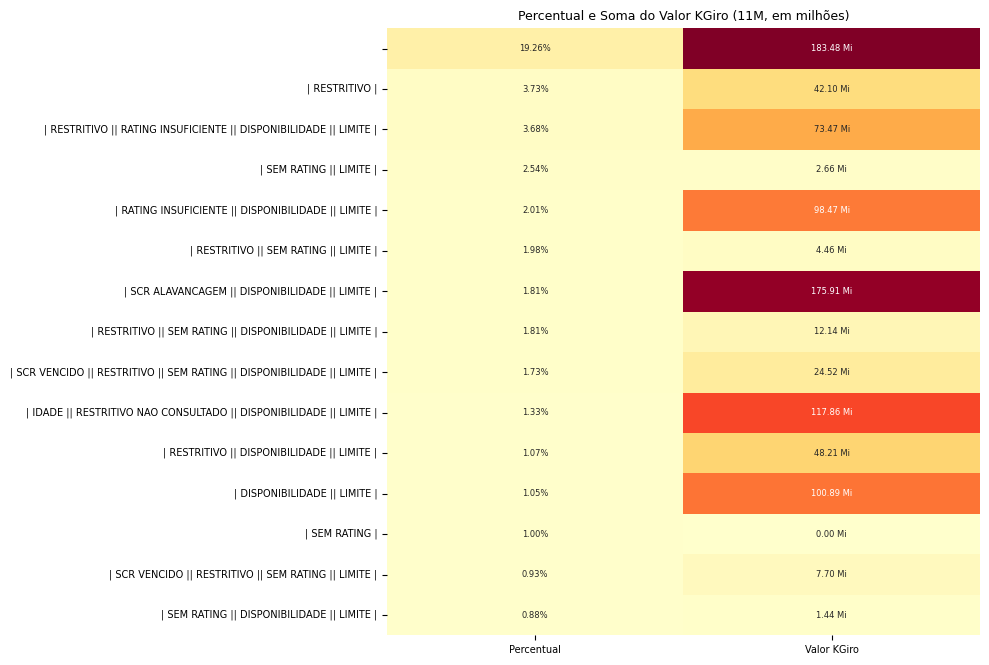

In [26]:
# ==========================
# 4) Heatmap-tabela: Razões x (Percentual, Soma)
# ==========================
data_plot = tabela[['Percentual', valor_col_plot]].copy()

# Garante que ambas as colunas são numéricas
for c in data_plot.columns:
    data_plot[c] = pd.to_numeric(data_plot[c], errors='coerce')

# (Opcional) se houver NaN, substitui por 0 para o heatmap
data_plot = data_plot.fillna(0.0)

# Labels personalizados por coluna (strings apenas para anotação)
labels = pd.DataFrame(index=data_plot.index, columns=data_plot.columns)
labels['Percentual'] = data_plot['Percentual'].map(lambda x: f"{x:.2f}%")

if SCALE_MILLIONS:
    labels[valor_col_plot] = data_plot[valor_col_plot].map(lambda x: f"{x:.2f} Mi")
else:
    labels[valor_col_plot] = data_plot[valor_col_plot].map(
        lambda x: f"{x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')
    )

plt.figure(figsize=(10, max(6, TOP_N * 0.45)))

sns.heatmap(
    data_plot.astype(float),
    annot=labels.to_numpy(),
    fmt="",
    cmap='YlOrRd',
    cbar=False,               # remove a escala da cor
    yticklabels=data_plot.index,
    annot_kws={"size": 6},    # texto dentro das células menor
)

plt.title('Percentual e Soma do Valor KGiro (11M, em milhões)', fontsize=9)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.ylabel('')
plt.xlabel('')
plt.tight_layout()
plt.show()



In [50]:
temporaria = base_kgiro_rosas[base_kgiro_rosas['RootDocumentNumber'].isin(document_rating)]
temporaria[(temporaria['check_var_pct_valorTomadoKGiro'] == 1)]['diff_valorTomadoKGiro'].sum()

185045687.90000004

In [51]:
len(document_rating)

3846

In [27]:
document_rating = base_elegibilidade_res_w[base_elegibilidade_res_w['reasons_not_elegible_translation'].isin(['| SCR ALAVANCAGEM || DISPONIBILIDADE || LIMITE |','| DISPONIBILIDADE || LIMITE |'])]['RootDocumentNumber']

In [28]:
query_rating = f""" SELECT * FROM `dataplatform-nonprd.credit_negocios.rating_vencedores`"""
df_rating = bf.read_gbq(query_rating)
base_rating = df_rating.to_pandas()

In [29]:
base_rating['RootDocumentNumber'] = base_rating['RootDocumentNumber'].astype(int)

In [30]:
base_rating[base_rating['RootDocumentNumber'].isin(document_rating)]['ModelVersion'].value_counts()

ModelVersion
CSv6.1/14     1575
CSv6.6/15      821
CSv6.3/9       721
CSv6.10/6      623
CSv6.7/7       532
CSv6.2/14      362
CSv6.4/5       268
CSUMv1/2       252
CSTon1.3/2     210
CSTon1.1/2      57
Name: count, dtype: int64[pyarrow]

In [39]:
base_rating[(base_rating['RootDocumentNumber'].isin(document_rating))&(base_rating['ModelVersion'] != 'CSv6.1/14')]['CreditRating'].value_counts()

CreditRating
5.5: 344-650      312
5.0: 515-675      282
5.0: 662-876      243
3.5: 336-515      181
4.0: 422-662      158
10.0: 802-1000    158
6.5: 785-864      118
6.0: 413-585      115
4.5: 581-704      114
6.5: 650-744      110
6.5: 675-742      106
5.5: 704-785       90
7.5: 363-592       85
9.5: 906-1000      84
7.5: 744-802       80
4.0: 157-413       78
2.5: 311-470       76
7.0: 640-733       75
9.0: 592-742       72
7.0: 742-778       71
4.0: 468-579       65
7.5: 585-705       64
3.5: 470-581       59
8.0: 864-906       59
8.0: 778-817       57
10.0: 832-1000     56
10.0: 855-1000     55
6.0: 615-683       50
10.0: 940-1000     49
3.5: 232-344       46
8.5: 705-764       44
4.5: 0-233         41
3.5: 325-462       40
8.5: 733-794       38
8.5: 817-855       37
5.5: 547-640       34
2.5: 277-422       33
9.5: 794-860       33
1.5: 0-336         32
7.0: 683-725       30
6.0: 233-363       27
10.0: 742-1001     27
10.0: 860-1000     26
6.0: 876-901       25
1.0: 0-311         

In [31]:
base_rating_w = base_elegibilidade_res_w.merge(base_rating,how='left',left_on=['RootDocumentNumber','data_application_score_processing_at'],right_on=['RootDocumentNumber','ProcessingDate'])

In [ ]:
base_rating_w[base_rating_w['CreditRating'] == '0.0: IsTPVUpperMedium']['rating_value'].value_counts()

In [32]:
(base_rating_w['CreditRating'].value_counts(normalize=True)*100).head(20)

CreditRating
0.0: IsTPVUpperMedium    31.896345
10.0: 802-1000            4.829243
10.0: 985-1000            3.919684
5.5: 344-650              3.878497
8.5: 972-985              2.399176
1.5: 0-232                2.306504
6.5: 650-744              2.200103
5.5: 894-940              2.110863
10.0: 832-1000            2.049082
5.0: 515-675              1.815686
4.0: 422-662               1.74704
7.5: 363-592              1.661232
10.0: 855-1000            1.637206
5.0: 662-876              1.565128
9.0: 592-742              1.547966
7.5: 744-802              1.517076
10.0: 742-1001            1.438133
4.5: 0-233                1.407242
3.5: 336-515              1.342028
1.5: 0-336                1.300841
Name: proportion, dtype: double[pyarrow]

In [33]:
base_rating_w[base_rating_w['CreditRating'] == '0.0: IsTPVUpperMedium']['reasons_not_elegible_translation'].value_counts().head(20)

reasons_not_elegible_translation
| SEM RATING || LIMITE |                                                                                                                 741
| RESTRITIVO || SEM RATING || LIMITE |                                                                                                   575
| RESTRITIVO || SEM RATING || DISPONIBILIDADE || LIMITE |                                                                                514
| SCR VENCIDO || RESTRITIVO || SEM RATING || DISPONIBILIDADE || LIMITE |                                                                 489
| SEM RATING |                                                                                                                           291
| SCR VENCIDO || RESTRITIVO || SEM RATING || LIMITE |                                                                                    266
| SEM RATING || DISPONIBILIDADE || LIMITE |                                                                              

In [ ]:
base_rating_w['CreditRating_I'] = pd.to_numeric(base_rating_w['CreditRating'].str[:2])

In [ ]:
document_rating = base_rating_w[base_rating_w['CreditRating_I'] == 10]['RootDocumentNumber']

In [37]:
df = pd.DataFrame(document_rating).astype(str).rename(columns={'RootDocumentNumber':'RootDocument'})
client = bigquery.Client(project = 'dataplatform-prd')

table_name = 'credit_negocios.document_winners'

job_config = bigquery.LoadJobConfig(write_disposition = "WRITE_TRUNCATE")
job = client.load_table_from_dataframe(df, table_name, job_config = job_config)

In [ ]:
base_rating['CreditRating'].value_counts().head(20)